In [3]:
import numpy as np
import numpy.linalg as lin
import numpy.random as rnd
from matplotlib import pyplot as plt
import numpy.linalg as lin
import random
import math
import warnings
warnings.filterwarnings("ignore")


def getFigure( sizex = 7, sizey = 7 ):
    fig = plt.figure( figsize = (sizex, sizey) )
    return fig

def plot2D( X, fig, color = 'r', marker = '+', size = 100, empty = False ):
    plt.figure( fig.number )
    if empty:
        plt.scatter( X[:,0], X[:,1], s = size, facecolors = 'none', edgecolors = color, marker = marker  )
    else:
        plt.scatter( X[:,0], X[:,1], s = size, c = color, marker = marker )


def genCrescentData( d, n, mu, r, flipped = False ):
    X = np.vstack( (np.cos( np.linspace( 0, np.pi, n ) ), np.sin( np.linspace( 0, np.pi, n ) ) ) ).T
    if flipped:
        X[:,1] = -np.abs( X[:,1] )
    else:
        X[:,1] = np.abs( X[:,1] )
    X = (X * r) + mu
    return X

def genSphericalData( d, n, mu, r ):
    X = rnd.normal( 0, 1, (n, d) )
    norms = lin.norm( X, axis = 1 )
    X = X / norms[:, np.newaxis]
    X = (X * r) + mu
    return X

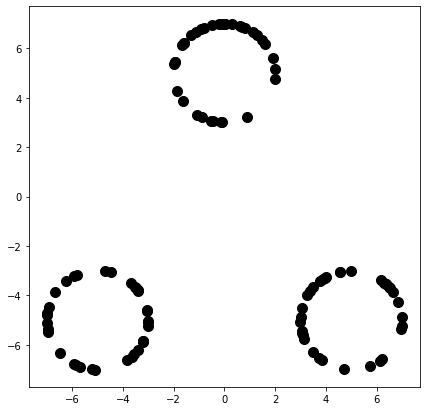

In [4]:
#generating spherical dataset
d = 2 
n = 35 
r = 2 

mu1 = np.array([0,5])
mu2 = np.array([-5,-5])
mu3 = np.array([5,-5])

tmp1 = genSphericalData(d,n,mu1,r)
tmp2 = genSphericalData(d,n,mu2,r)
tmp3 = genSphericalData(d,n,mu3,r )
gmm_X = np.vstack((tmp1,tmp2,tmp3))

fig = getFigure( 7, 7 )
plot2D( gmm_X, fig, color = 'k', marker = 'o' )

The multivariate normal pdf is given as: <br>
$p(x;\mu, \Sigma) = \frac{1}{(2\pi)^{n/2} |\Sigma| ^{1/2}} exp(\frac{-(x-\mu)^T \Sigma^{-1} (x-\mu))}{2}$ where $\mu$ is the mean and the $\Sigma$ is the covariance

In [5]:
#this function returns the multivariate normal pdf

def multivariate_normal_pdf(X, mean, covariance):
        return (2*np.pi)**(-len(X)/2)*np.linalg.det(covariance)**(-1/2)*np.exp(-np.dot(np.dot((X-mean).T, np.linalg.inv(covariance)), (X-mean))/2)

The bivariate normal distribution probability distribution is given as: <br>

$P(x1,x2) = \frac{1}{2 \pi \sigma_1 \sigma_2 \sqrt{1-\rho^2}} exp(\frac{-z}{2(1-\rho^2)})$<br>
where z is $\frac{(x_1-\mu_1)^2}{\sigma^2_{1}} - \frac{2 \rho(x_1-\mu_1)(x_2 - \mu_2)}{\sigma_1\sigma_2} + \frac{(x_2-\mu_2)^2}{\sigma^2_{2}}$ and $\rho = \frac{covariance}{\sigma_1\sigma_2}$

In [6]:
# this is a helper function for the below plot_contours function and returns the bivariate normal

def bivariate_normal(X, Y, sigmax, sigmay,mux, muy, sigmaxy):
    Xmu = X-mux
    Ymu = Y-muy
    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

In [7]:
#this function is used to plot the contours

def plot_contours(data, means, covs,n_cluster, title):
    plt.figure()
    plt.rcParams["figure.figsize"]=(7, 6)
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko')

    delta = 0.25
    r1 = np.linspace(np.min(data[:, 0]), np.max(data[:, 1]), 250)
    r2 = np.linspace(np.min(data[:, 1]), np.max(data[:, 1]), 250)
    X, Y = np.meshgrid(r1, r2)
    col = ['green', 'red', 'indigo']
    for i in range(n_cluster):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        Z = bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()

We can check for convergence as below<br>
During the E step we use the formula $\sum^{K}_{l=1}\pi_l N(x_n|\mu_l,\Sigma_l)$ If we assume that the data are sampled iid then the overall likelihood can be written as $P(X|\pi ,\mu,\Sigma) = \prod_{n=1}^{N}\sum^{K}_{l=1}\pi_l N(x_i|\mu_l,\Sigma_l)$ which can be interpreted as we multiply all the probability of every data point to obtain a single number which will estimates the likelihood of the data fitted under the model's current parameter. We will be using log likelihood which make the computation a little easier as below<br>
$ln(P(X|\pi ,\mu,\Sigma)) = \sum_{n=1}^{N}ln(\sum^{K}_{l=1}\pi_l N(x_i|\mu_l,\Sigma_l))$ so if the log likelihood of the original data under model current parameter is less than the specified tolerance (did not improved much) then we can say that the algorithm as converged.

In [8]:
def EM_for_GMM(data,n_cluster,max_iter,tol,title):
    
    #initilisating the model parameters
    mu= []
    cov = []
    
    for i in range(n_cluster):
        mu.append(np.random.randn(2))    # np.random.random(n) gives n random floating numbers
        cov.append(np.eye(2))            # np.eye(n) gives n*n diagonal matrix with diagonal enteries being same(1)
    pi = np.array(np.full(n_cluster, 1 / n_cluster))
    
    n_samples,n_dimensions=data.shape    # Here we will have number of samples and features of the data
    resp = np.zeros([n_samples,n_cluster]) # Initializing the expected assignments to zeroes
    log_likelihood = 0    # Variable to keep track of the log likelihood under current models parameters
    
    for loop in range(max_iter):
        
        # E-step
        '''
        here we will calculate the expected assignment
        in the below loop we will find the gaussian pdf multiplied by the mixture weights and sum them for all clusters and get
        the denominator then we will use the same denominator to calculate the numerator for every number of clusters where 
        we will use the updated mean and covariance to find the numerator after which we will update the expected assignment 
        '''
        for n in range(n_samples):
            denominator = 0.0
            
            for k in range(n_cluster):
                val = multivariate_normal_pdf(data[n],mu[k],cov[k]) #multivariate normal pdf for current mean and covariance
                denominator+=pi[k] * val
                
        
            for k in range(n_cluster):
                val = multivariate_normal_pdf(data[n],mu[k],cov[k]) #multivariate normal pdf for updated mean and covariance 
                numerator = pi[k]*val
                resp[n,k] = numerator/denominator #updating the expected assignment
                
                
        # M-step
        # here we are updating the model paramters(no updating for mixture weights pi) using the above derived formlae

        for k in range(n_cluster):
            N_k = 0   # this variable will store the number of points within a cluster
            for i in resp[:,k]:
                N_k+=i
                
            # updating the mean mu
            mu[k] = 0.0
            for n in range(n_samples):
                val = resp[n,k]*data[n]
                mu[k]+= 1/N_k * val  
                
                
            # updating the covariance cov    
            cov[k] = np.zeros([n_dimensions,n_dimensions])
            num=0
            for n in range(n_samples):
                val = ((data[n]-mu[k])*np.vstack(data[n]-mu[k])) # here we are using np.vstack to transpose the difference
                num+=val*resp[n,k]
            prod = n_dimensions*N_k
            cov[k] = num/prod 
                
                
        
        # convergence checking
        
        new_log_likelihood= 0 #this variable will store the likelihood for the current models parameter   
        for r in range(n_samples):        
            log_lik_sum = 0  # this variable will store the sum of all the log likelihoods
        
            for j in range(n_cluster):
                first_term = pi[j]
                second_term = np.array(multivariate_normal_pdf(data[r],mu[j],cov[j]))
                prod = first_term * second_term
                log_lik_sum += prod
            new_log_likelihood+= np.log(log_lik_sum) # log likelihood under the current model's paramters
         
        # here we are checking if the change between the iterations is less than the pre-specified tolerance
        if abs(new_log_likelihood - log_likelihood) <= tol: 
            print('converged at iteration number',loop)
            break
            
            
        #if the algorithm has not converged we will store and check it in the next iteration   
        log_likelihood = new_log_likelihood 
                
    plot_contours(data,mu,cov,n_cluster,title)

converged at iteration number 7


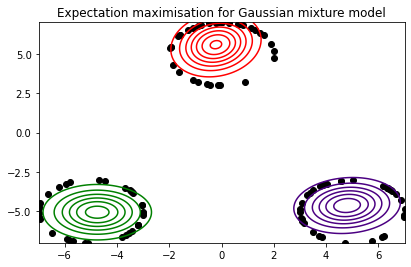

In [9]:
tol = 0.001
k = 3
max_iter = 50
title = 'Expectation maximisation for Gaussian mixture model'
EM_for_GMM(gmm_X,k,max_iter,tol,title)